# Imports

In [1]:
import os

from dotenv import load_dotenv
from langchain_mistralai import ChatMistralAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity
from langchain.prompts import ChatPromptTemplate
from langchain_mistralai import MistralAIEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

# Load API KEY

In [2]:
load_dotenv()
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

# Load model

In [3]:
from langchain_mistralai import ChatMistralAI

model = ChatMistralAI(model="mistral-large-latest", api_key=MISTRAL_API_KEY)

In [4]:
prompt_text = "Which Iranian football team has the most trophies?"
model.invoke(prompt_text)

AIMessage(content="As of my last update in October 2023, Persepolis FC is generally considered the Iranian football team with the most trophies. Persepolis has a rich history and has won numerous titles, including multiple Iranian Pro League championships, Hazfi Cups, and other domestic and international honors.\n\nFor the most current information, it's always best to check the latest statistics or official club records, as the number of trophies can change with new seasons and competitions.", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 15, 'total_tokens': 123, 'completion_tokens': 108}, 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-46a9dff2-bcba-4319-929c-fb7ac41c407a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 108, 'total_tokens': 123})

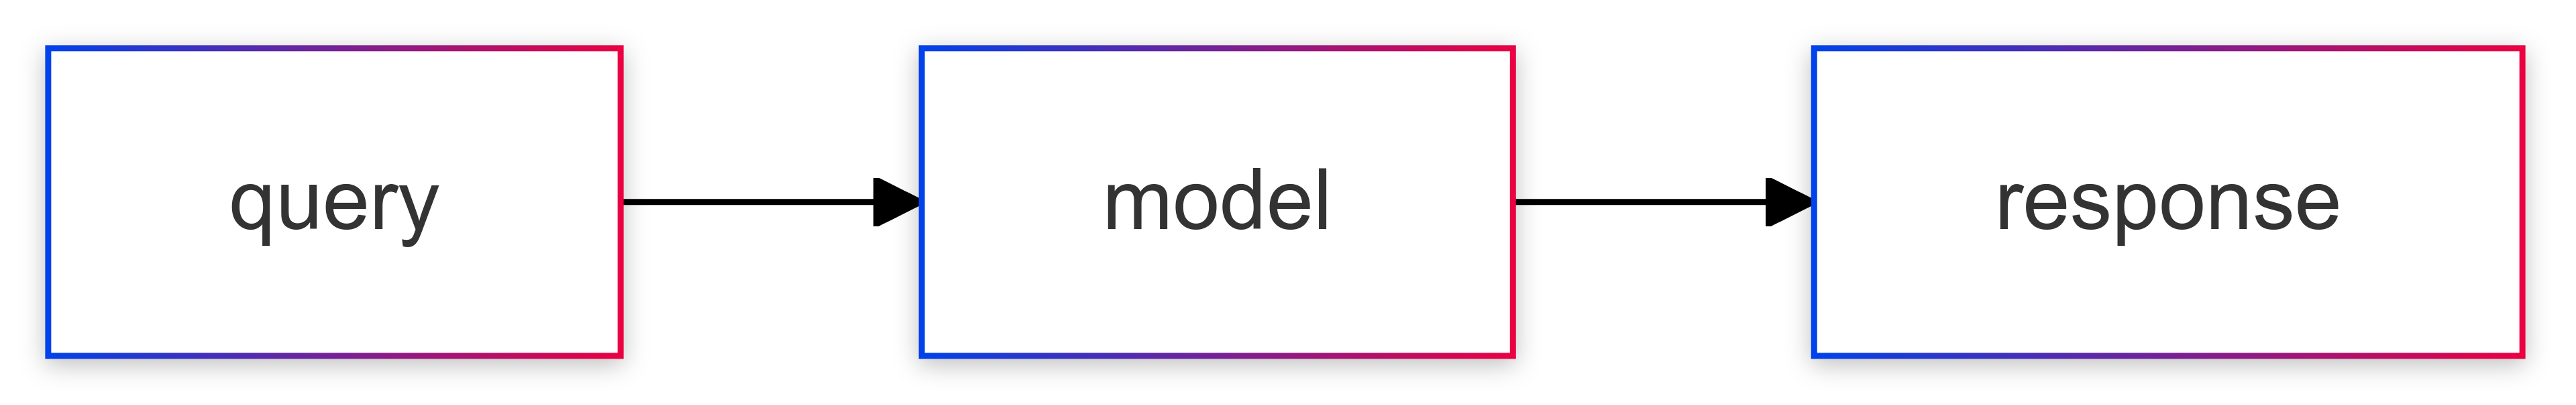

In [5]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

chain = model | parser
chain.invoke(prompt_text)

'As of my current knowledge up to 2023, the Iranian football team with the most trophies is Persepolis FC. Persepolis is one of the most successful and popular football clubs in Iran, with a rich history of domestic and international achievements. They have won numerous titles in the Iranian Pro League (formerly known as the Iranian Premier Football League), as well as several Hazfi Cups (the Iranian domestic cup competition).\n\nPersepolis has also had notable performances in the AFC Champions League, making them a formidable force in Iranian and Asian football. However, for the most up-to-date information, it is always best to check the latest statistics and records, as new achievements and trophies may have been added since my last update.'

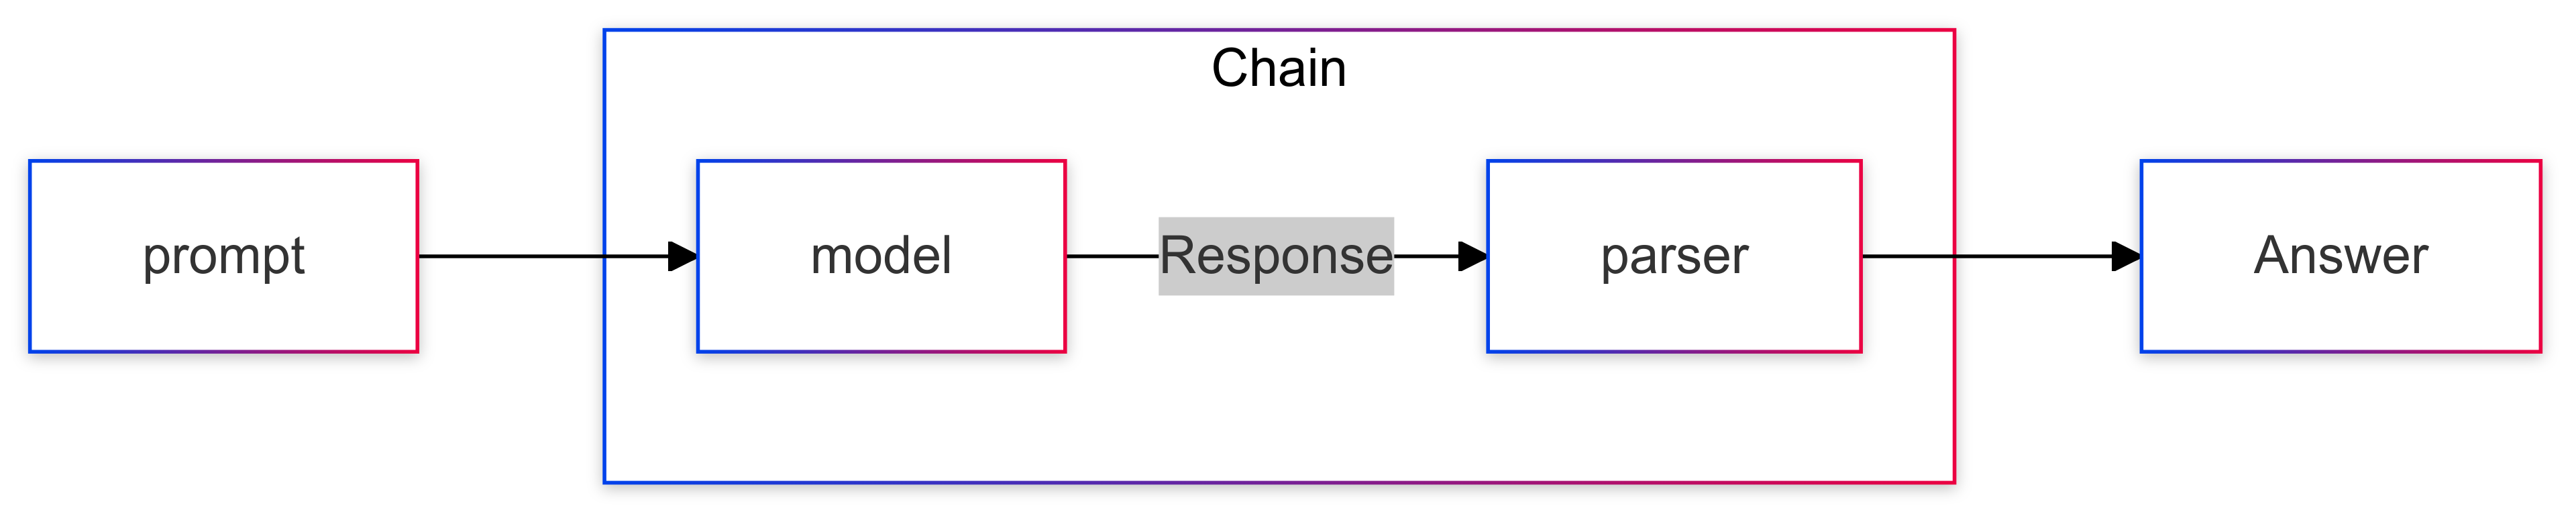

In [6]:
example_template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know". If you know the answer, answer in more details in two lines.

Context: {context}

Question: {question}
"""
# from langchain.prompts import ChatPromptTemplate


example_prompt = ChatPromptTemplate.from_template(example_template)

In [7]:
chain = example_prompt | model | parser
chain.invoke({
    "context": "Kian is from Iran.",
    "question": "Where is Mohammad from?"
})
# add more details to the context

"I don't know."

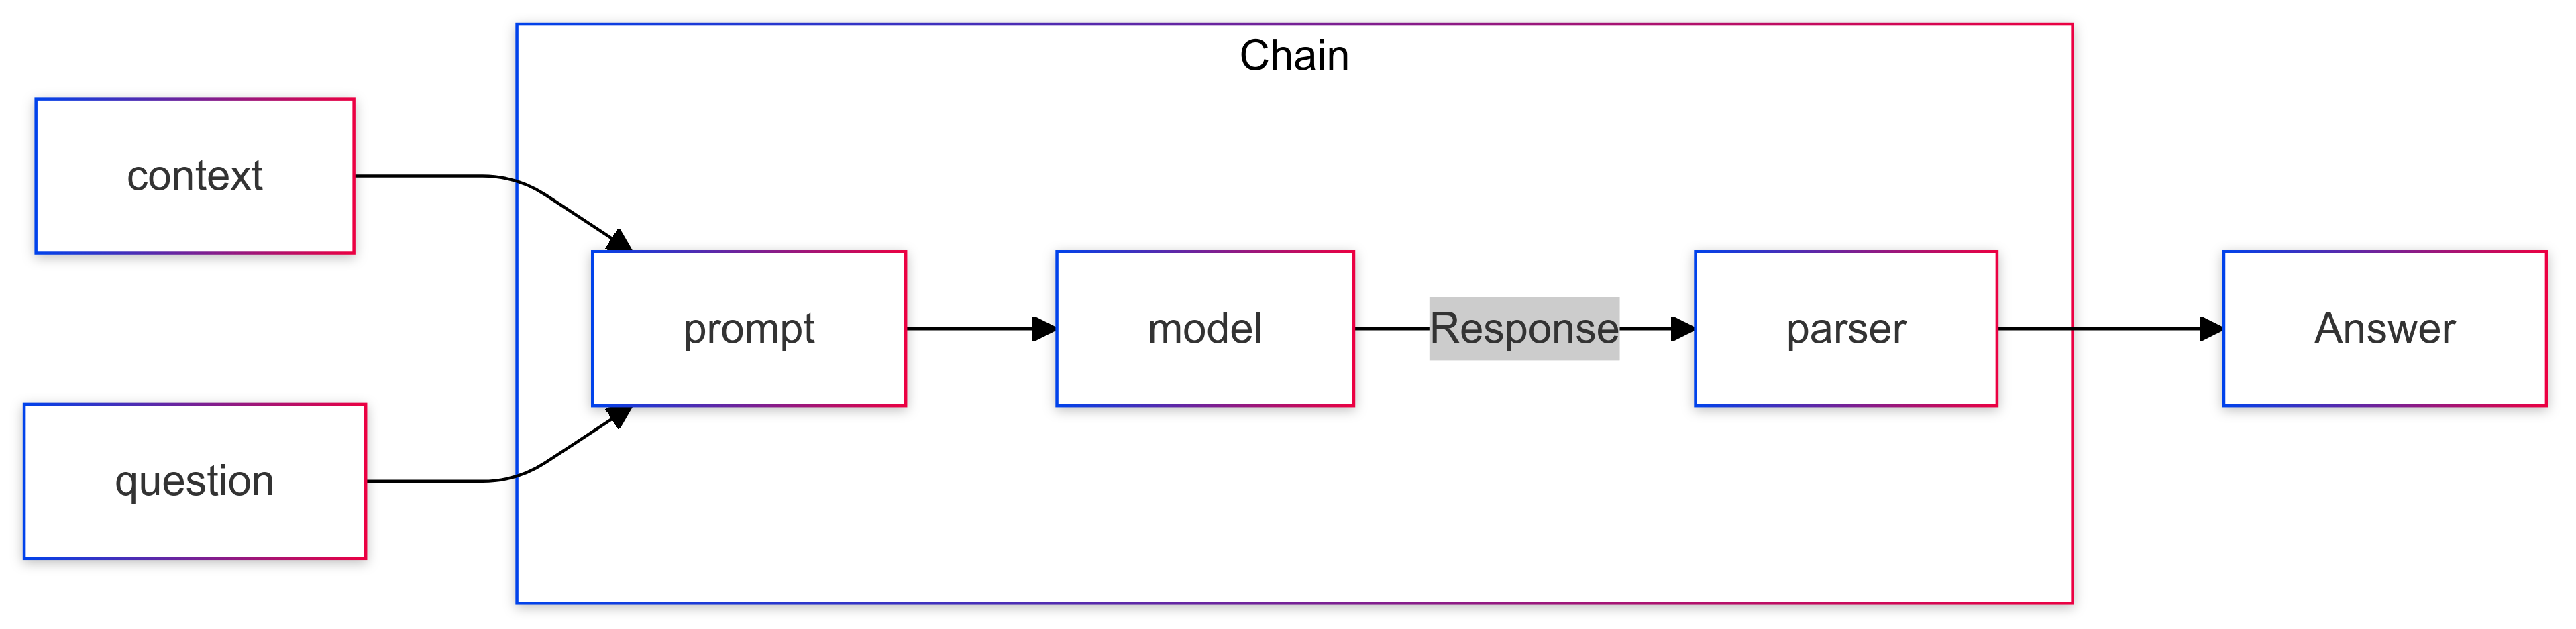

### Chains

In [8]:
template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".

Context: {context}  

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [10]:
chain = prompt | model | parser
translation_template = """
Translate the {answer} to {language}
Only write the tranlated answer.
"""
translation_prompt = ChatPromptTemplate.from_template(translation_template)
translation_chain = (
    {"answer": chain, "language": itemgetter("language")} | translation_prompt | model | parser
)
translation_chain.invoke(
    {
        "context":"Kian is Iranian.",
        "question": "Where is Mohammad from?",
        "language": "Chinese"
        }
        )

'我不知道。'

![Untitled diagram-2025-01-28-144758.png](<attachment:Untitled diagram-2025-01-28-144758.png>)
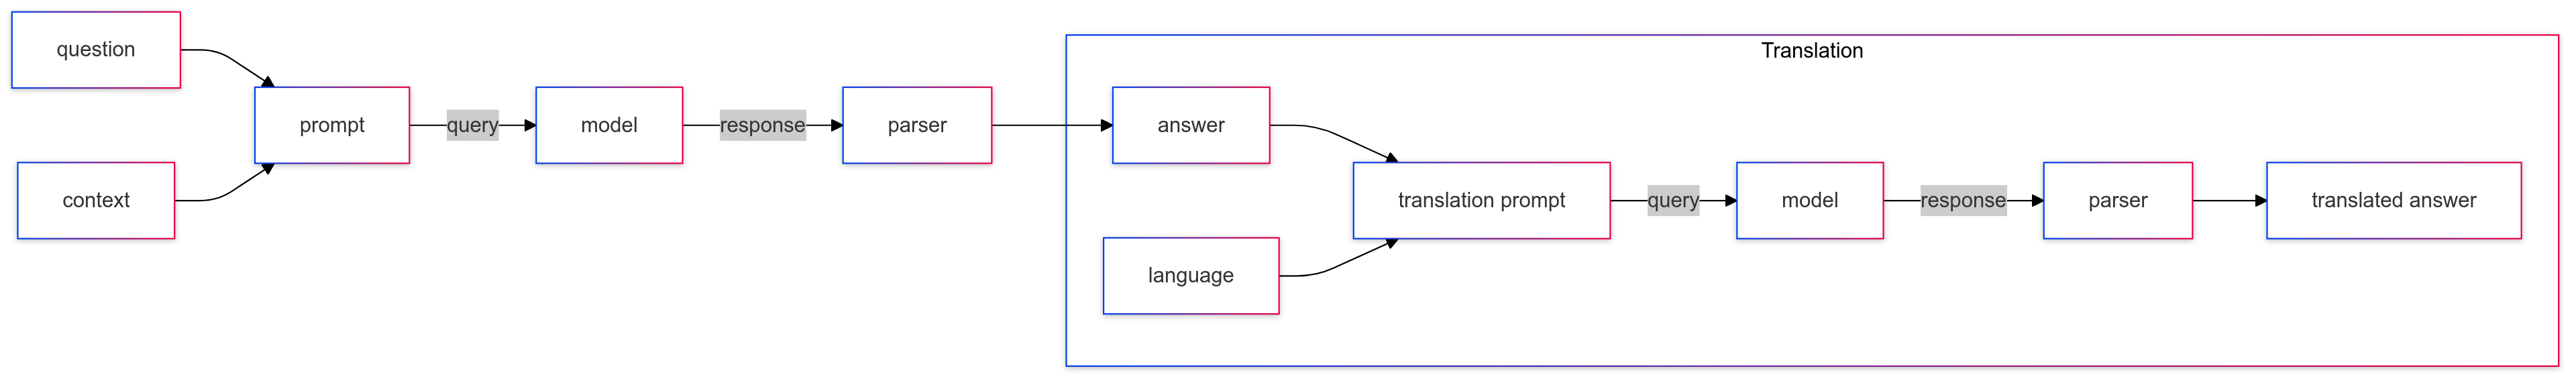

# Prompt Engineering

## In-context learning

### Zero Shot Learning

In [11]:
template_zero_shot = """
You are an expert sentiment classifier. Classify the following sentence as 
"Positive", "Negative", or "Neutral". 
Sentence: "{sentence}"
"""

prompt_zero_shot = ChatPromptTemplate.from_template(template_zero_shot)
chain_zero_shot = prompt_zero_shot | model | parser

response_zero_shot = chain_zero_shot.invoke({"sentence": "I love this movie."})
print(response_zero_shot)

The sentiment of the sentence "I love this movie." is **Positive**.


### One-shot Learning

In [13]:
template1 = """
You are an expert sentiment classifier. Classify the sentence below as "Positive", "Negative", or "Neutral",
based on the example provided.

Example:
sentence: "This movie is awesome!"
Sentiment: Positive

Now, classify this new sentence:
"{sentence}"
"""

prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"sentence": "This movie was normal"})
print(response)


Sentiment: Neutral


### Few-shot Learning

In [14]:
template1 = """
You are an expert sentiment classifier. Classify the sentence below as "Positive", "Negative", or "Neutral",
based on the examples provided.

Examples:
sentence: "This movie is awesome!"
Sentiment: Positive

sentence: "This is bad!"
Sentiment: Negative

sentence: "This movie was normal."
Sentiment: Neutral

Now, classify this new sentence:
"{sentence}"
"""

prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"sentence": "I love this movie."})
print(response)


Positive


### Role/Persona Prompts

In [15]:
template1 = """
Answer the question. If you can't answer the question, reply "I don't know".
Question: "{question}"
"""
prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"question": "What is world war 2?"})
print(response)

World War II, also known as the Second World War, was a global conflict that took place from 1939 to 1945. It involved many of the world's nations, including all of the great powers, which eventually formed two opposing military alliances: the Allies and the Axis. The war was the deadliest conflict in human history, resulting in an estimated 70–85 million fatalities worldwide, or about 3% of the global population. It was marked by significant events and developments such as the Holocaust, the atomic bombings of Hiroshima and Nagasaki, and the emergence of the United States and the Soviet Union as superpowers.


In [16]:
template1 = """
You are a kindergarden teacher for 5 year old students. One of the students asked you the question below, answer it so he/she can understand.

Question: "{question}"
"""

prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"question": "What is world war2?"})
print(response)

Alright, let's imagine you and your friends are playing in the sandbox. Usually, you all play nicely together, sharing your toys and having fun. But one day, some of your friends started arguing and fighting over who should have the most toys. Then, some other friends joined in, and soon there were two big groups fighting. This went on for a long time, and it was very sad because no one was playing nicely anymore.

World War 2 was like that big argument in the sandbox, but it happened between countries a long time ago. Two groups of countries had a big fight, and it lasted for many years. It was very sad, and many people got hurt. But eventually, they stopped fighting and started working together again, just like you and your friends would after a disagreement.

It's important to learn from this and always try to solve problems by talking and sharing, not by fighting. That's why we teach you to be kind and friendly to everyone in our classroom!


### Structured Output

In [17]:
template1 = """
You are an AI assistant that returns structured JSON. When asked a question, respond with a JSON object containing:
- "short_answer": a concise, one-sentence answer.
- "long_answer": a detailed explanation in at least 100 words.
- "sources": a list of any references cited.
question: "{question}"
"""

prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"question": "Where is Paris?"})
print(response)

```json
{
  "short_answer": "Paris is in France.",
  "long_answer": "Paris, the capital city of France, is located in the northern part of the country. It is situated on the Seine River and is known for its iconic landmarks such as the Eiffel Tower, Louvre Museum, and Notre-Dame Cathedral. Paris is a major European city and a global center for art, fashion, gastronomy, and culture. It is also the most populous city in France and serves as a significant financial and commercial hub.",
  "sources": [
    "Encyclopedia Britannica - Paris",
    "Wikipedia - Paris"
  ]
}
```


### Chain of Thought

In [18]:
template1 = """
You are a math tutor. Answer the question.
question: "{question}"
"""

prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"question": "Where is the integral of x^2?"})
print(response)

The integral of \( x^2 \) is found using the power rule for integration, which states that the integral of \( x^n \) is \( \frac{x^{n+1}}{n+1} \) plus a constant \( C \).

For \( x^2 \), where \( n = 2 \):

\[ \int x^2 \, dx = \frac{x^{2+1}}{2+1} + C = \frac{x^3}{3} + C \]

So, the integral of \( x^2 \) is:

\[ \frac{x^3}{3} + C \]

where \( C \) is the constant of integration.


In [19]:
template1 = """
You are a math tutor. Explain your reasoning step by step before giving the final answer.
question: "{question}"
"""

prompt1 = ChatPromptTemplate.from_template(template1)
chain1 = prompt1 | model | parser
response = chain1.invoke({"question": "Where is the integral of x^2?"})
print(response)

To find the integral of \( x^2 \), we need to determine the antiderivative of \( x^2 \). The integral of a function \( f(x) \) is another function \( F(x) \) such that the derivative of \( F(x) \) is \( f(x) \).

Let's go through the steps to find the integral of \( x^2 \).

### Step 1: Understanding the Integral
The integral of \( x^2 \) can be written as:
\[ \int x^2 \, dx \]

### Step 2: Using the Power Rule for Integration
The power rule for integration states that if \( f(x) = x^n \), then the integral of \( f(x) \) is given by:
\[ \int x^n \, dx = \frac{x^{n+1}}{n+1} + C \]
where \( C \) is the constant of integration.

### Step 3: Applying the Power Rule
In our case, \( n = 2 \). So, we apply the power rule:
\[ \int x^2 \, dx = \frac{x^{2+1}}{2+1} + C \]

### Step 4: Simplifying the Expression
Simplify the exponent and the denominator:
\[ \int x^2 \, dx = \frac{x^3}{3} + C \]

### Final Answer
Therefore, the integral of \( x^2 \) is:
\[ \int x^2 \, dx = \frac{x^3}{3} + C \]

Thi

## RAG Retrieval-Augmented Generation

### Embedding example

In [20]:
embeddings = MistralAIEmbeddings()
embedded_query = embeddings.embed_query("Where is Kian from?")

print(f"Embedding length: {len(embedded_query)}")
print(embedded_query[:10])

/home/kian/anaconda3/envs/Rag_aaiss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kian/anaconda3/envs/Rag_aaiss/lib/python3.12/site-packages/langchain_mistralai/embeddings.py:180: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


Embedding length: 1024
[-0.043914794921875, 0.0325927734375, 0.04888916015625, 0.010955810546875, 0.0357666015625, 0.0180511474609375, 0.05419921875, -0.046417236328125, -0.018402099609375, -0.01849365234375]


In [23]:
sentence1 = embeddings.embed_query("Kian is Iranian.")
sentence2 = embeddings.embed_query("Mohammad is Kian's friend.")

#### Similarity between vectors

In [24]:
query_sentence1_similarity = cosine_similarity([embedded_query], [sentence1])[0][0]
query_sentence2_similarity = cosine_similarity([embedded_query], [sentence2])[0][0]

query_sentence1_similarity, query_sentence2_similarity

(0.8757909372360628, 0.8217219366091549)

### In-memory Vectore DB

In [26]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings


documents = [
        "Kian's friend is Mohammad.",
        "Mohammad works in Snapp.",
        "Kian is Iranian.",
        "Kian studies Competer Science.",
        "Kian has a sister.",
        "Mohammad has two brothers."
    ]

vectorstore1 = DocArrayInMemorySearch.from_texts(documents,embedding=embeddings)

ImportError: Could not import docarray python package. Please install it with `pip install docarray`.

In [ ]:
vectorstore1.similarity_search_with_score(query="How many brothers does Mohammad have?", k=3)

[(Document(metadata={}, page_content='Mohammad has two brothers.'),
  0.8820931543788917),
 (Document(metadata={}, page_content='Mohammad works in Snapp.'),
  0.752736546864568),
 (Document(metadata={}, page_content="Kian's friend is Mohammad."),
  0.7523545902526636)]

#### Add Vector DB to Chain

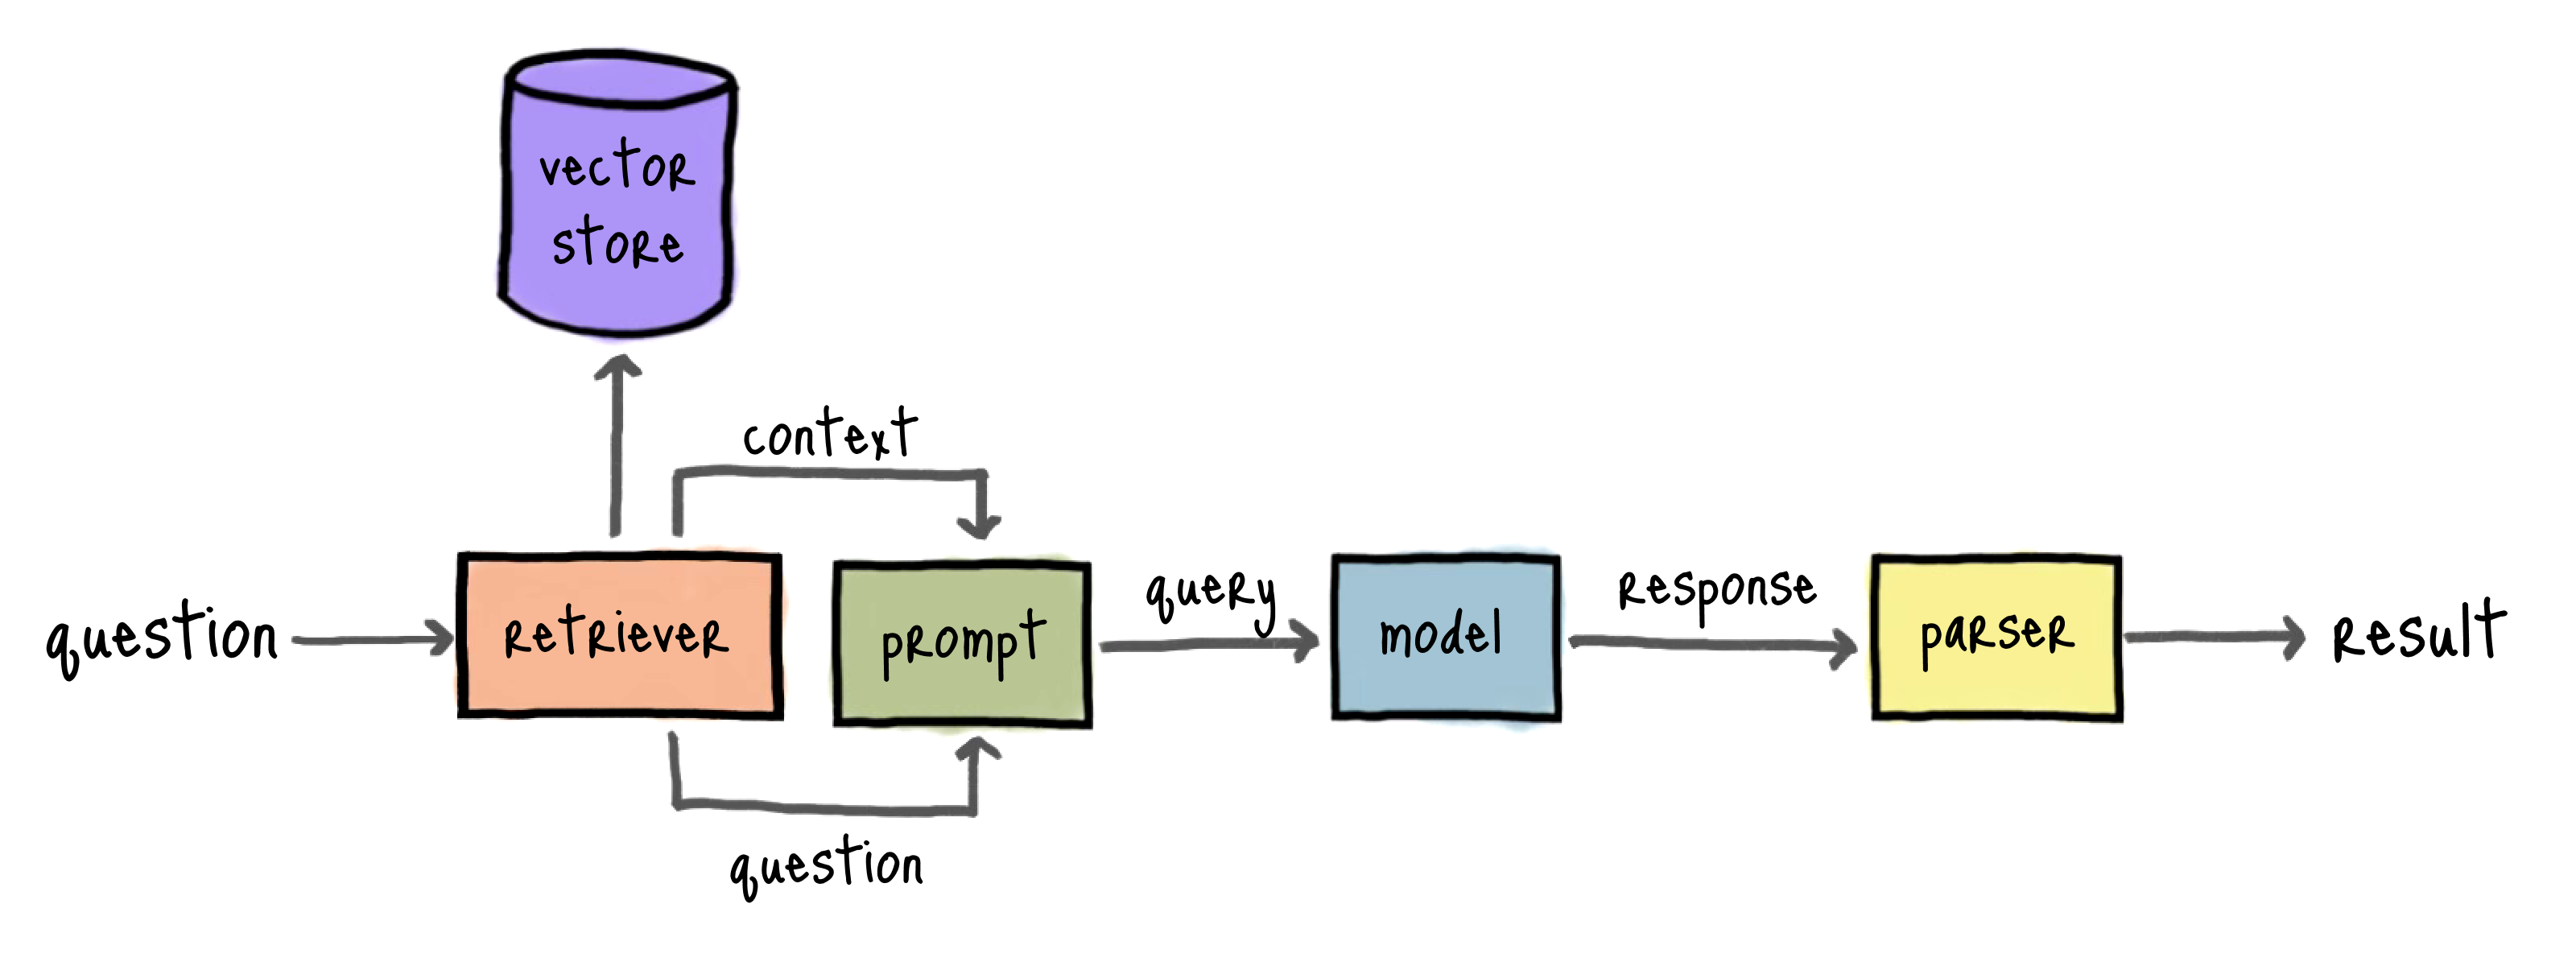

In [27]:
question = "Who is Kian's friend?"
retriever1 = vectorstore1.as_retriever()
retriever1.invoke(question)

NameError: name 'vectorstore1' is not defined

In [ ]:
setup = RunnableParallel(context=retriever1, question=RunnablePassthrough())
setup.invoke(question)

{'context': [Document(metadata={}, page_content="Kian's friend is Mohammad."),
  Document(metadata={}, page_content='Kian has a sister.'),
  Document(metadata={}, page_content='Kian is Iranian.'),
  Document(metadata={}, page_content='Kian studies Competer Science.')],
 'question': "Who is Kian's friend?"}

In [ ]:
chain = setup | prompt | model | parser
chain.invoke("How many brother's does mohammad have?")

'Mohammad has two brothers.'

### Read the PDF

In [ ]:
model.invoke("Who is the president of Iran?")

AIMessage(content="As of my last update in October 2023, the President of Iran is Ebrahim Raisi. He took office on August 8, 2021. However, political positions can change, so it's always a good idea to check the most recent sources for the latest information.", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 10, 'total_tokens': 75, 'completion_tokens': 65}, 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-f8d9f92b-05c0-4447-a423-a845fea1778d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 65, 'total_tokens': 75})

In [ ]:
pip install pypdf

Note: you may need to restart the kernel to use updated packages.


In [28]:
PDF_FILE = '2024_Iranian_presidential_election.pdf'
loader = PyPDFLoader(PDF_FILE)
pages = loader.load()

print(f"Number of pages: {len(pages)}")
print(f"Length of a page: {len(pages[1].page_content)}")
print("Content of a page:", pages[1].page_content)

Number of pages: 31
Length of a page: 728
Content of a page: 2024 Iranian presidential election
28 June 2024 (first round)5 July 2024 (second round)
Registered 61,452,321
Turnout 39.93% (first round) 
  8.55pp49.68% (second round)
 
Nominee MasoudPezeshkian Saeed Jalili
Party Independent Independent
Alliance Reformists Principlists
Popular vote 16,384,403 13,538,179
Percentage 54.76% 45.24%
President beforeelection
Mohammad Mokhber(acting) First VicePresident of EbrahimRaisiIndependent
Elected President
Masoud PezeshkianIndependent
Following the announcement of Raisi's death on 20 May, authorities announced that votingwould be held on 28 June.[1] Registration of candidates began on 30 May and ran until 3June,[34] while campaigning lasted from 12 June until 27 June.[1]
Candidates


In [29]:
full_text = ""
for page in pages:
    full_text += page.page_content

In [31]:
full_text[:100]

'2024 Iranian presidential election\nEarly presidential elections in Iran were held on 28 June and 5 J'

In [32]:
chain = prompt | model | parser

In [33]:
try:
    print(chain.invoke({
        "context": full_text,
        "question": "Who won the election?"
    }))
except Exception as e:
    print(e)

Masoud Pezeshkian won the election.


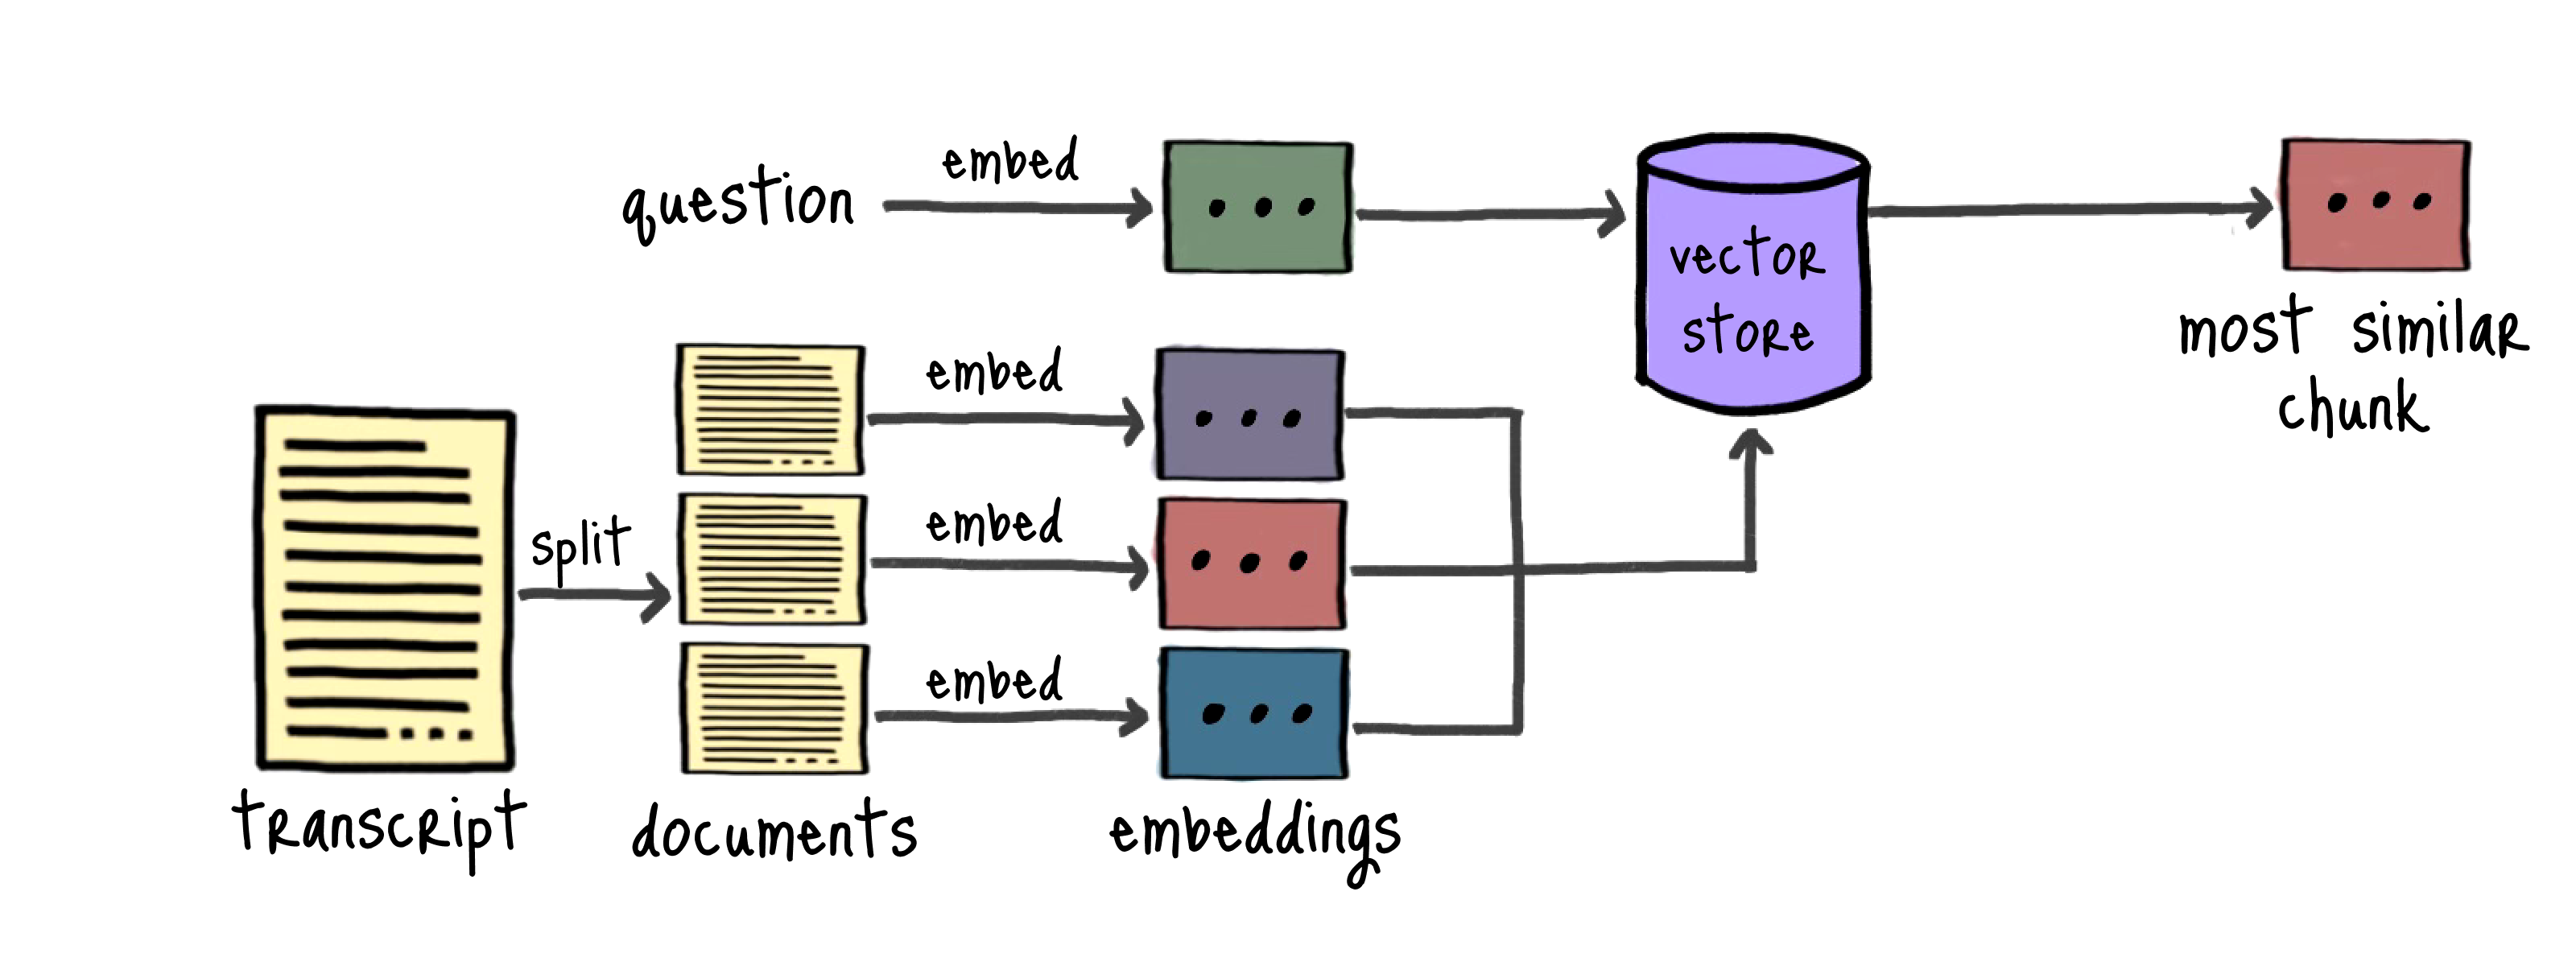

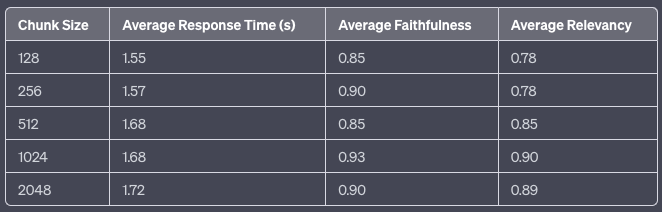

In [34]:
def chunk_text(text, chunk_size=512, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return splitter.split_text(text)

chunks = chunk_text(full_text)

In [35]:
print(f"Number of chunks: {len(chunks)}")
print(f"Length of a chunk: {len(chunks[1])}")
print("Content of a chunk:", chunks[1])

Number of chunks: 385
Length of a chunk: 507
Content of a chunk: Four candidates contested the first round of the election, in which Masoud Pezeshkian won 44%, Saeed Jalili won 40%, Mohammad Bagher Ghalibafwon 14% and Mostafa Pourmohammadi won less than 1% of the vote. Pezeshkian was the only reformist candidate on the ballot.[3] As no candidatewon a majority in the first round, a run off vote was held on 5 July between Jalili and Pezeshkian,[4] which the latter won with 53.7% of the vote. On6 July 2024, the Ministry of Interior declared Pezeshkian the winner of the


In [36]:
chunks[2]

'of Interior declared Pezeshkian the winner of the election,[5] with Jalili conceding defeat shortly thereafter.[6]'

### Use Pinecone

In [37]:
embedding_model = MistralAIEmbeddings()
PINE_CONE_API_KEY = os.getenv("PINECONE_API_KEY")

/home/kian/anaconda3/envs/Rag_aaiss/lib/python3.12/site-packages/langchain_mistralai/embeddings.py:180: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [41]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [39]:
from langchain_pinecone import PineconeVectorStore

In [42]:
vectorstore = PineconeVectorStore.from_texts(
    texts=chunks,
    embedding=embeddings,
    index_name="aaiss-prod"
    )

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 100})

In [ ]:
setup = RunnableParallel(context=retriever, question=RunnablePassthrough())
chain = setup | prompt | model | parser
chain.invoke("How many candidates registered for the election? and how many approved")

'A total of 80 people, including four women, filed their candidacies for president. Six candidates were approved by the Guardian Council to run for president.'

In [ ]:
chain.invoke("Name all the candidates who approved for the election. Who they are?")

'The candidates approved for the election are:\n\n1. **Mohammad Bagher Ghalibaf**\n   - Born: 23 August 1961 (age 63), Torqabeh, Iran\n   - Experience: Speaker of the Islamic Consultative Assembly (since 2020), Member of Expediency Discernment Council (2017–2020), Mayor of Tehran (2005–2017), Presidential candidate (2005, 2013, 2017)\n   - Party: Progress and Justice Population of Islamic Iran\n   - Result: Lost in the first round\n\n2. **Saeed Jalili**\n   - Born: 6 September 1965 (age 59), Mashhad, Iran\n   - Experience: Member of the Expediency Discernment Council (since 2013), Secretary of the Supreme National Security Council (2007–2013), Chief Nuclear Negotiator (2007–2013), Presidential candidate (2013, 2021)\n   - Party: Independent\n   - Result: Lost in the run-off round\n\n3. **Masoud Pezeshkian**\n   - Born: 29 September 1954 (age 70), Mahabad, Iran\n   - Experience: Member of the Islamic Consultative Assembly (2008–2024), Minister of Health and Medical Education (2001–2005)